In [1]:
import numpy as np
from scipy.special import gamma, kv
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

# Random Variate Generation

Many times in industry, it is useful to be able to draw from random distributions that are not in your random number library. This is a well-studied problem, but it may be something that *you* have not studied.

## Selected Distributions

Here are the density functions for a few probability distributions that are very likely not in your library of random variate generators.

In [2]:
def von_karman(x):
    "von Karman correlation function"
    x = np.abs(x)
    return 2**(2/3)/gamma(1/3) * x**(1/3) * kv(1/3, x)

## Metropolis Hastings Sampler

+ These samplers need a burn-in period.
+ If your proposal distribution is Gaussian, it is a *random walk* Metropolis Hastings sampler.
+ You are shooting for an acceptance rate of about 0.3.

In [3]:
class MetropolisHastings:
    def __init__(self, f, g):
        # 'f' is your target distribution.
        #     It only has to be porportional to the target distribution.
        #     It is assumed to be hard to sample from, but reasonable to evaluate.
        # 'g' Is your proposal distribution.
        #     Here it is assumed to be symmetric.
        
        self.f = f
        self.g = g
        self.accept_rate = 0.5
        self.ewma = 0.001

        self.x = g()
        self.fx = f(self.x)
        
    def __call__(self):
        x_cand = self.x + self.g()
        fcand = self.f(x_cand)
        a = min(1, fcand/self.fx)
        u = np.random.random_sample()
        if a >= u:
            self.x = x_cand
            self.fx = fcand
            self.accept_rate = self.ewma + (1 - self.ewma)*self.accept_rate
        else:
            self.accept_rate = (1 - self.ewma)*self.accept_rate
            
        return self.x

The good news is that as of here, we have a symmetric Metropolis-Hastings sampler. The bad news is that we don't really have any tools for tuning this thing so that is generates variates that we can rely on. We now need to be able to tune our proposal distribution so that the acceptance rate is about 0.3. I tried a lot of optimizers, but only `scipy.optimize.differential_evolution` worked for me. I think you need a global optimizer, and the acceptance ratio is a noisy output. You will really want to dial down the tolerance for convergence as well. If you're using this in real code, you should do a lot more checking.

In [4]:
OPTIMAL_ACCEPTANCE = 0.3
SAMPLES = 10000

def get_acceptance_ratio(p):
    # I have hard-coded a proposal distribution.
    # I have hard-coded a trial distribution.
    s = lambda : np.random.normal(0, p)
    d = MetropolisHastings(von_karman, s)
    [d() for k in range(SAMPLES)]
    return abs(d.accept_rate - OPTIMAL_ACCEPTANCE)

result = differential_evolution(get_acceptance_ratio, [(0.1, 10)], atol=0.1)
print(result)
best_parameter = result.x[0]

     fun: 0.0001586922528260537
 message: 'Optimization terminated successfully.'
    nfev: 80
     nit: 1
 success: True
       x: array([4.06780407])


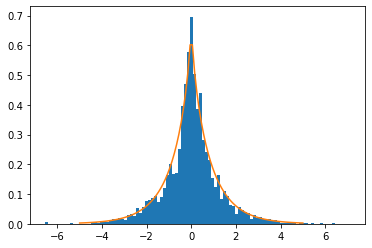

In [5]:
s = lambda : np.random.normal(0, 4)
d = MetropolisHastings(von_karman, s)
v = [d() for k in range(9000)]
x = np.linspace(-5, 5, 100)
y = von_karman(x)
y /= -np.trapz(x, y)

plt.hist(v, bins=101, density=True)
plt.plot(x, y)
plt.show()

## Gibbs Sampler